# **Bell Theorem**

Bell's theorem or inequality proves that entanglement based
observations can't be reproduced with any local realist theory [1].
This example shows Bell inequality in form of CHSH game where two
players Alice and Bob receive an input bit x and y respectively and
produce an output a and b based on the input bit.

The goal is to maximize the probability to satisfy the condition [2]:

    a XOR b = x AND y
In the classical deterministic case, the highest probability
achievable is 75%. While with quantum correlations, it can
achieve higher success probability. In the quantum case, two players
Alice and Bob starts with a shared Bell-pair entangled state. The
random input x and y is provided by referee for Alice and Bob. If
the input x (and y) is 0, Alice (Bob) rotates in Y-basis by angle
-pi/16 and if the input is 1, Alice (Bob) rotates by angle 3pi/16.
This is implemented here by a default rotation gate of -pi/16
followed by a custom controlled-rotation gate in Y-basis that 
rotates by angle of pi/4 if input from referee is 1. The success
probability for the above condition will be cos(pi/8)^2 ~ 85.3%

[1] https://en.wikipedia.org/wiki/Bell%27s_theorem

[2] R. de Wolf. Quantum Computing: Lecture Notes (arXiv:1907.09415, Section 15.2)

In [ ]:
!pip install cirq --quiet

     |████████████████████████████████| 1.4MB 2.8MB/s 


In [ ]:
import cirq
import numpy as np
from cirq.contrib.svg import SVGCircuit

In [ ]:
def bitstring(bits):
    return ''.join('1' if e else '_' for e in bits)

In [58]:
# Using R(theta) gate
class CRy(cirq.TwoQubitGate):

    def __init__(self, theta):
        self.theta = theta

    def _unitary_(self):
            
      sintheta = np.sin(self.theta)
      costheta = np.cos(self.theta)
      
      return np.array([
          [1, 0, 0,               0],
          [0, 1, 0,               0],
          [0, 0, costheta,        -sintheta],
          [0, 0, sintheta,       costheta]
      ])
    
    def _circuit_diagram_info_(self, args):
        # the @ is for control
        return '@', 'Ry({}π)'.format(self.theta / np.pi)

In [64]:
# Adapting for R. de Wolf notations 
def bell_cirqit():
  alice = cirq.GridQubit(0,0)
  bob = cirq.GridQubit(1,0)
  alice_referee = cirq.GridQubit(0,1)
  bob_referee = cirq.GridQubit(1,1)

  circuit = cirq.Circuit()
  # Shared entangled states
  circuit.append([cirq.H(alice),
        cirq.CNOT(alice, bob),
        cirq.Z(alice),])
  
  # Referees flip coins.
  circuit.append([
        cirq.H(alice_referee),
        cirq.H(bob_referee),
    ])

  # Players do a sqrt(X) based on their referee's coin.
  circuit.append([
        cirq.ry(-np.pi/16)(alice),
        cirq.Circuit(CRy(np.pi/4)(alice_referee, alice)),
        cirq.ry(-np.pi/16)(bob),
        cirq.Circuit(CRy(np.pi/4)(bob_referee, bob)),
    ]) 

  # Then results are recorded.
  circuit.append([
        cirq.measure(alice, key='a'),
        cirq.measure(bob, key='b'),
        cirq.measure(alice_referee, key='x'),
        cirq.measure(bob_referee, key='y'),
    ])
  return circuit 

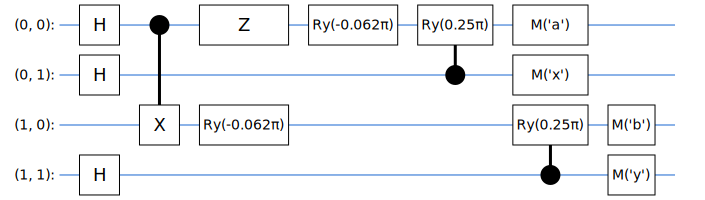

In [65]:
circuit = bell_cirqit()
SVGCircuit(circuit)

In [66]:
# Simmulation
repetitions = 75
result = cirq.Simulator().run(program=circuit, repetitions=repetitions)

In [67]:
#  Collect results.
a = np.array(result.measurements['a'][:, 0])
b = np.array(result.measurements['b'][:, 0])
x = np.array(result.measurements['x'][:, 0])
y = np.array(result.measurements['y'][:, 0])
outcomes = a ^ b == x & y
win_percent = len([e for e in outcomes if e]) * 100 / repetitions

In [68]:
# Print data.
print('Results')
print('a:', bitstring(a))
print('b:', bitstring(b))
print('x:', bitstring(x))
print('y:', bitstring(y))
print('(a XOR b) == (x AND y):\n  ', bitstring(outcomes))
print('Win rate: {}%'.format(win_percent))

Results
a: 11_____11___111111_11_1_1111_111111__11__1___11__11_1___1_1_1__111_11__1_11
b: 11_______1_1_11_11_1_1_1_111_1_1111_1__1111_1_11_1_1____1_1_1__11_______111
x: 1__1____11_1___1____11111_____11_____1111_111__1___1_1_11__1_____11_111111_
y: ______1111_11__1___111111___1_1_11_1_1111___11_1__111_1______1_1___11__1___
(a XOR b) == (x AND y):
   1111111_1111_11111111111111111111111_11111_11_1111_1_111111111111_1_1111_11
Win rate: 86.66666666666667%
